<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_50802/18357977.py:10: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(filename, sep='\s+', header=None, names=['Wavelength_nm', 'Intensity'], dtype=float)


Rayleigh Scattering Line found at: 533.9 nm (Intensity: 2161410.5)

Identified Raman Peaks and their Shifts:
----------------------------------------
Wavelength (nm) | Intensity | Raman Shift (cm^-1) | Type
-----------------------------------------------------------------
521.0           | 9680.5    | -463.8              | Anti-Stokes
525.1           | 12337.0   | -313.9              | Anti-Stokes
527.6           | 17519.4   | -223.7              | Anti-Stokes
540.4           | 34936.2   | 225.3               | Stokes
543.2           | 36234.8   | 320.7               | Stokes
547.6           | 46889.3   | 468.6               | Stokes
556.8           | 7353.0    | 770.3               | Stokes
557.7           | 7262.4    | 799.3               | Stokes


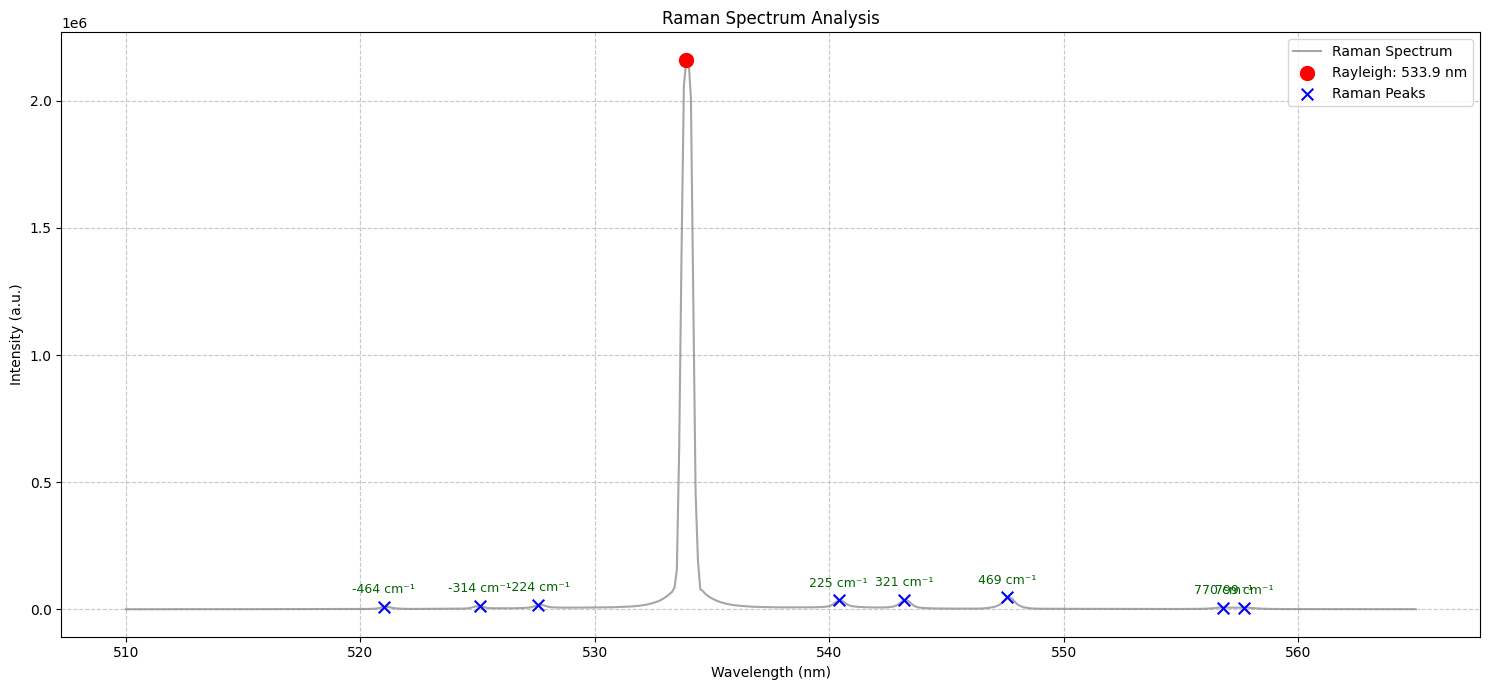


Note: Peak finding parameters (height, prominence, distance) in the `find_peaks` function might need adjustment for different datasets or to refine peak selection.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Define the filename
filename = 'finetune.txt'
# 1. Read the data
try:
    df = pd.read_csv(filename, sep='\s+', header=None, names=['Wavelength_nm', 'Intensity'], dtype=float)
except FileNotFoundError:
    print(f"Error: The file '{filename}' was not found. Please make sure it's in the same directory.")
    exit()
except Exception as e:
    print(f"Error reading the file: {e}")
    exit()

# Convert to numpy arrays for easier handling with scipy
wavelengths = df['Wavelength_nm'].values
intensities = df['Intensity'].values

# 2. Find the Rayleigh scattering line
# This is typically the most intense peak in the spectrum.
rayleigh_idx = np.argmax(intensities)
rayleigh_wavelength = wavelengths[rayleigh_idx]
rayleigh_intensity = intensities[rayleigh_idx]

print(f"Rayleigh Scattering Line found at: {rayleigh_wavelength:.1f} nm (Intensity: {rayleigh_intensity:.1f})")

# 3. Find Raman peaks
# We need to set some parameters for find_peaks.
# 'height': minimum intensity of a peak. Let's try a value significantly above baseline noise but below Rayleigh.
# 'prominence': how much a peak stands out from its surroundings.
# 'distance': minimum horizontal distance (in number of data points) between neighboring peaks.
# These parameters often require tuning based on the specific spectrum.

# Estimate noise level or use a fraction of max intensity, but be careful of the Rayleigh peak.
# Let's try an absolute height first. Visual inspection of data suggests peaks of interest are > 1000.
# The data points are 0.1 nm apart, so a distance of 5 points means peaks must be at least 0.5 nm apart.
peak_indices, properties = find_peaks(
    intensities,
    height=1500,      # Minimum intensity for a peak
    prominence=500,   # Minimum prominence
    distance=5        # Minimum distance between peaks in data points
)

# Filter out the Rayleigh peak from the identified Raman peaks
raman_peak_indices = []
raman_peak_wavelengths = []
raman_peak_intensities = []

for idx in peak_indices:
    # Check if this peak is too close to the Rayleigh peak (e.g., within 0.5 nm)
    if np.abs(wavelengths[idx] - rayleigh_wavelength) > 0.5: # Ensure it's not the Rayleigh peak itself
        raman_peak_indices.append(idx)
        raman_peak_wavelengths.append(wavelengths[idx])
        raman_peak_intensities.append(intensities[idx])

raman_peak_wavelengths = np.array(raman_peak_wavelengths)
raman_peak_intensities = np.array(raman_peak_intensities)


# 4. Calculate Raman shifts (Raman frequency)
# Raman shift (cm^-1) = (1/lambda_excitation_nm - 1/lambda_raman_nm) * 10^7
# Or, more commonly for Stokes/Anti-Stokes: (1/lambda_0 - 1/lambda_s) * 10^7
# where lambda_0 is excitation (Rayleigh) wavelength.
# Positive shifts are Stokes lines (longer wavelength), negative are Anti-Stokes (shorter wavelength).

raman_shifts_cm_minus_1 = []
if rayleigh_wavelength > 0: # Avoid division by zero if Rayleigh not found (though unlikely with argmax)
    for r_wl in raman_peak_wavelengths:
        if r_wl > 0: # Avoid division by zero
            shift = ((1 / rayleigh_wavelength) - (1 / r_wl)) * 1e7
            raman_shifts_cm_minus_1.append(shift)
        else:
            raman_shifts_cm_minus_1.append(np.nan) # Should not happen with real data
else:
    raman_shifts_cm_minus_1 = [np.nan] * len(raman_peak_wavelengths)

print("\nIdentified Raman Peaks and their Shifts:")
print("----------------------------------------")
print("Wavelength (nm) | Intensity | Raman Shift (cm^-1) | Type")
print("-----------------------------------------------------------------")
for i in range(len(raman_peak_wavelengths)):
    peak_type = "Stokes" if raman_shifts_cm_minus_1[i] > 0 else "Anti-Stokes" if raman_shifts_cm_minus_1[i] < 0 else "N/A"
    print(f"{raman_peak_wavelengths[i]:<15.1f} | {raman_peak_intensities[i]:<9.1f} | {raman_shifts_cm_minus_1[i]:<19.1f} | {peak_type}")


# 5. Plot the spectrum and mark the peaks
plt.figure(figsize=(15, 7))
plt.plot(wavelengths, intensities, label='Raman Spectrum', color='grey', alpha=0.7)
plt.scatter(rayleigh_wavelength, rayleigh_intensity, color='red', s=100, zorder=5, label=f'Rayleigh: {rayleigh_wavelength:.1f} nm')
plt.scatter(raman_peak_wavelengths, raman_peak_intensities, color='blue', s=70, zorder=5, marker='x', label='Raman Peaks')

# Annotate Raman peaks with their shifts
for i in range(len(raman_peak_wavelengths)):
    plt.annotate(f'{raman_shifts_cm_minus_1[i]:.0f} cm⁻¹',
                 (raman_peak_wavelengths[i], raman_peak_intensities[i]),
                 textcoords="offset points",
                 xytext=(0,10), # Offset text slightly above the peak
                 ha='center',
                 fontsize=9,
                 color='darkgreen')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (a.u.)')
plt.title('Raman Spectrum Analysis')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust y-axis for better visibility if dynamic range is very large
# If the Rayleigh peak is overwhelmingly dominant, consider a log scale or truncating y-axis for Raman peaks.
# For this data, the Rayleigh peak is extremely intense.
# We might want to show the full scale first, then potentially a zoomed-in version or log scale.
# For simplicity, let's keep linear scale for now. Users can adjust if needed.
max_raman_intensity = np.max(raman_peak_intensities) if len(raman_peak_intensities) > 0 else rayleigh_intensity
# If you want to focus on Raman peaks and Rayleigh is too high:
# plt.ylim(0, max_raman_intensity * 2) # or some other factor
# Or use a log scale for y-axis:
# plt.yscale('log')

plt.tight_layout()
plt.show()

# Optional: Save the plot
# plt.savefig("raman_spectrum_analysis.png")

print("\nNote: Peak finding parameters (height, prominence, distance) in the `find_peaks` function might need adjustment for different datasets or to refine peak selection.")


Processing 0-deg (Parallel):
  Original Rayleigh peak at: 534.00 nm (Intensity: 262573.7)
  Fitted Rayleigh (Gaussian): Amp=268603.4, Mean=533.93, StdDev=0.16
  Found 13 Raman peaks on subtracted spectrum for 0-deg (Parallel).

Processing 90-deg (Perpendicular):
  Original Rayleigh peak at: 534.30 nm (Intensity: 1173523.9)
  Fitted Rayleigh (Gaussian): Amp=1228086.2, Mean=534.23, StdDev=0.17
  Found 39 Raman peaks on subtracted spectrum for 90-deg (Perpendicular).

--- Peak Matching and Depolarization Ratios ---
   shift_0deg (cm-1) wl_0deg (nm) I_parallel shift_90deg (cm-1) I_perpendicular depol_ratio
0             -642.0        516.3      102.3             -633.8           209.1       2.044
1             -507.9        519.9      101.5             -518.4           250.5       2.468
2             -467.3        521.0      113.7             -470.4          1311.9      11.538
3             -317.4        525.1      590.7             -320.7          1100.6       1.863
4             -227.2 

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_50802/2986606413.py:12: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(filename, sep='\s+', header=None, names=['Wavelength_nm', 'Intensity'], dtype=float)


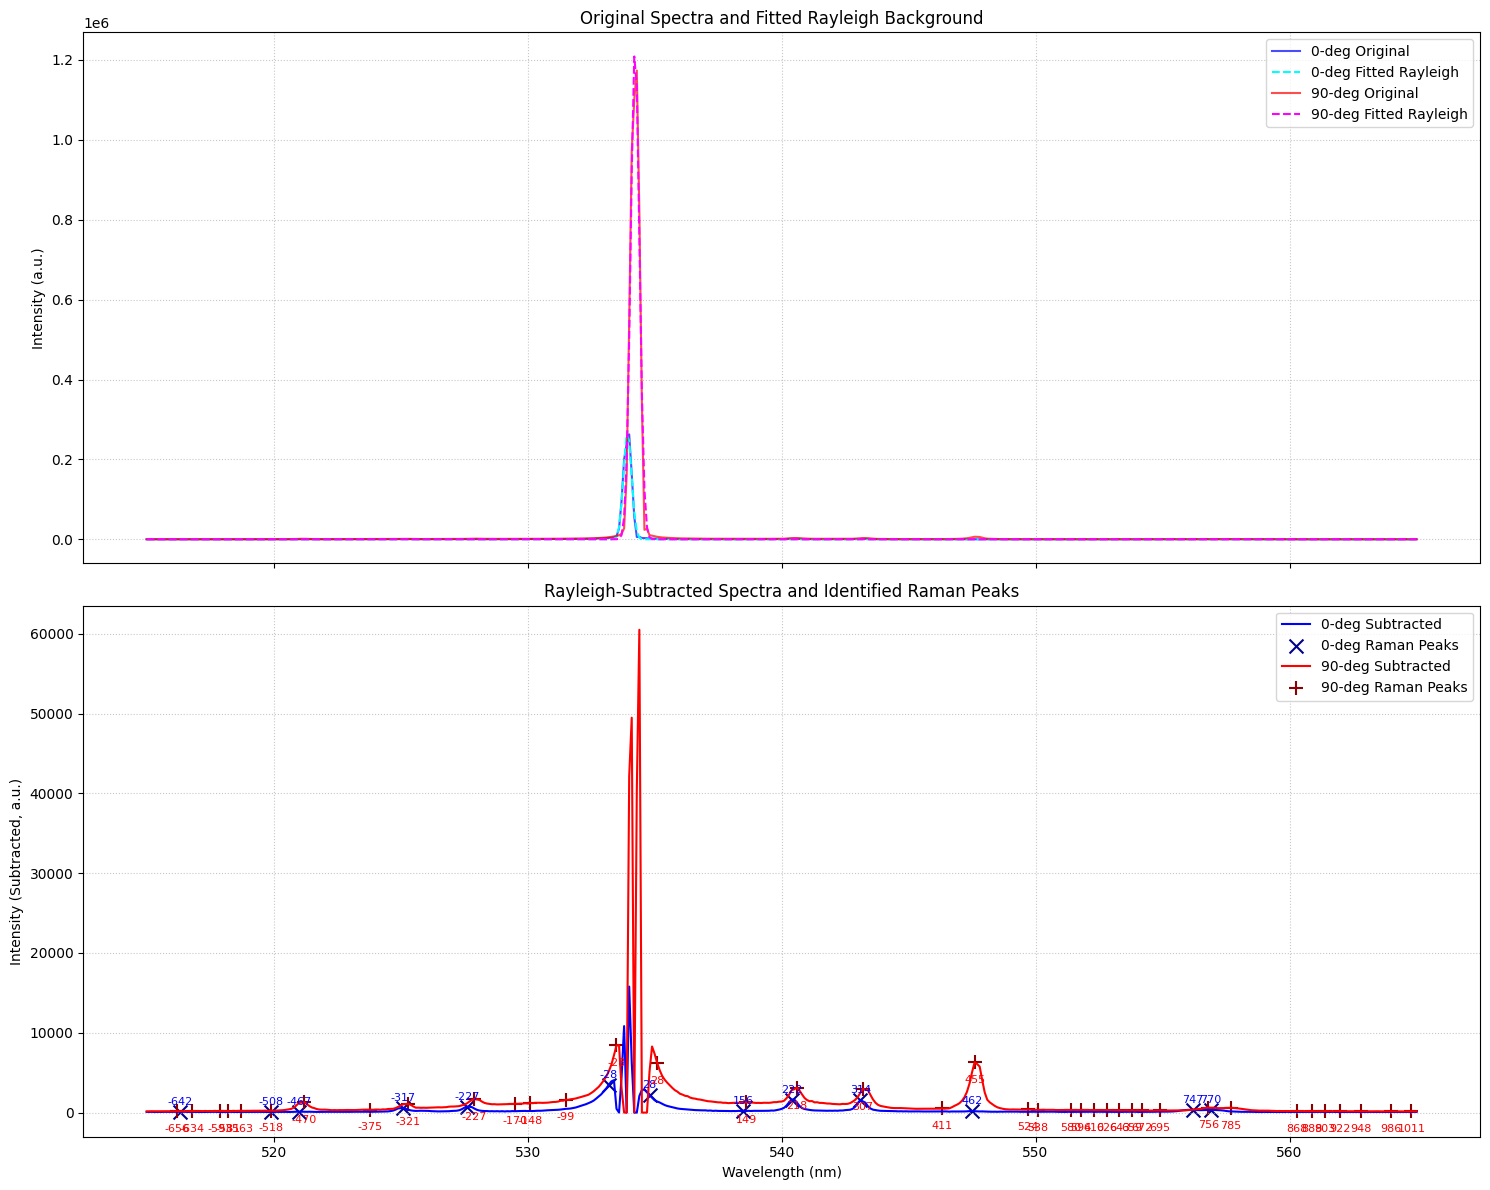


Notes:
- The quality of Rayleigh subtraction depends heavily on the chosen `rayleigh_fit_window_nm` and the appropriateness of the Gaussian model.
- `peak_find_prominence` and `peak_find_distance` for `find_peaks` on subtracted data are crucial and may need tuning.
- `shift_tolerance_cm_minus_1` for peak matching determines how strictly peaks are paired.
- Depolarization ratios are sensitive to the accuracy of intensity measurements and background subtraction.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# --- Helper Functions ---

def load_spectrum(filename):
    """
    Loads spectrum data from a file.

    Parameters:
        filename (str): Path to the spectrum data file. The file should contain two columns:
                        wavelength (nm) and intensity, separated by whitespace.

    Returns:
        tuple: (wavelengths, intensities) as numpy arrays.
               Returns (None, None) if the file cannot be loaded.
    """
    try:
        # Read the file using pandas, assuming whitespace separator and no header
        df = pd.read_csv(filename, sep='\s+', header=None, names=['Wavelength_nm', 'Intensity'], dtype=float)
        return df['Wavelength_nm'].values, df['Intensity'].values
    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
        return None, None
    except Exception as e:
        print(f"Error reading the file {filename}: {e}")
        return None, None

def gaussian(x, amplitude, mean, stddev):
    """Gaussian function for fitting."""
    return amplitude * np.exp(-((x - mean) / stddev)**2 / 2)

def calculate_raman_shifts(wavelengths_nm, rayleigh_wl_nm):
    """Calculates Raman shifts in cm^-1."""
    if rayleigh_wl_nm <= 0 or not np.all(wavelengths_nm > 0):
        return np.full_like(wavelengths_nm, np.nan)
    # Raman shift (cm^-1) = (1/lambda_excitation_nm - 1/lambda_raman_nm) * 10^7
    # Ensure wavelengths_nm is an array for vectorized operation
    wavelengths_nm_arr = np.array(wavelengths_nm)
    shifts = ((1 / rayleigh_wl_nm) - (1 / wavelengths_nm_arr)) * 1e7
    return shifts

def process_spectrum(wavelengths_orig, intensities_orig, label, rayleigh_fit_window_nm=1.5, peak_find_prominence=10, peak_find_distance=5):
    """
    Processes a Raman spectrum: fits and subtracts the Rayleigh peak, finds Raman peaks, and calculates Raman shifts.

    Parameters:
        wavelengths_orig (np.ndarray): Wavelengths of the original spectrum (nm).
        intensities_orig (np.ndarray): Intensities of the original spectrum.
        label (str): Label for logging/identification.
        rayleigh_fit_window_nm (float): Window size (nm) around Rayleigh peak for Gaussian fitting.
        peak_find_prominence (float): Prominence threshold for Raman peak finding.
        peak_find_distance (int): Minimum distance (in data points) between detected peaks.

    Returns:
        dict: Processed spectrum data including subtracted intensities, fitted Rayleigh, Raman peaks, and shifts.
    """
    if wavelengths_orig is None or intensities_orig is None:
        return None

    # 1. Find original Rayleigh peak (maximum intensity point)
    rayleigh_idx_orig = np.argmax(intensities_orig)
    rayleigh_wl_orig = wavelengths_orig[rayleigh_idx_orig]
    rayleigh_int_orig = intensities_orig[rayleigh_idx_orig]
    print(f"\nProcessing {label}:")
    print(f"  Original Rayleigh peak at: {rayleigh_wl_orig:.2f} nm (Intensity: {rayleigh_int_orig:.1f})")

    # 2. Fit Gaussian to Rayleigh peak within a specified window
    fit_mask = (wavelengths_orig >= rayleigh_wl_orig - rayleigh_fit_window_nm / 2) & \
               (wavelengths_orig <= rayleigh_wl_orig + rayleigh_fit_window_nm / 2)
    x_fit = wavelengths_orig[fit_mask]
    y_fit = intensities_orig[fit_mask]

    if len(x_fit) < 3:  # Not enough points to fit
        print(f"  Warning: Not enough points in window to fit Rayleigh peak for {label}. Skipping subtraction.")
        intensities_subtracted = intensities_orig.copy()
        fitted_rayleigh_peak = np.zeros_like(intensities_orig)
    else:
        # Initial guesses for Gaussian parameters: amplitude, mean, stddev
        p0 = [np.max(y_fit), rayleigh_wl_orig, rayleigh_fit_window_nm / 4]
        try:
            params, covariance = curve_fit(gaussian, x_fit, y_fit, p0=p0, maxfev=5000)
            # Generate the fitted Gaussian curve over the entire spectrum
            fitted_rayleigh_peak = gaussian(wavelengths_orig, *params)
            # 3. Subtract the fitted Rayleigh peak from the original spectrum
            intensities_subtracted = intensities_orig - fitted_rayleigh_peak
            intensities_subtracted[intensities_subtracted < 0] = 0  # Ensure no negative intensities
            print(f"  Fitted Rayleigh (Gaussian): Amp={params[0]:.1f}, Mean={params[1]:.2f}, StdDev={params[2]:.2f}")
        except RuntimeError:
            print(f"  Error: Could not fit Gaussian to Rayleigh peak for {label}. Using original intensities for peak finding.")
            intensities_subtracted = intensities_orig.copy()
            fitted_rayleigh_peak = np.zeros_like(intensities_orig)

    # 4. Find Raman peaks on the subtracted spectrum
    # Suppress region around Rayleigh peak to avoid picking up residuals from imperfect subtraction
    intensities_for_peak_finding = intensities_subtracted.copy()
    rayleigh_suppression_mask = (wavelengths_orig >= rayleigh_wl_orig - 0.7) & \
                                (wavelengths_orig <= rayleigh_wl_orig + 0.7)  # +/- 0.7 nm around Rayleigh
    intensities_for_peak_finding[rayleigh_suppression_mask] = 0

    # Set a minimum height for peak finding based on the subtracted spectrum's median intensity
    median_subtracted_intensity = np.median(intensities_subtracted[intensities_subtracted > 0]) if np.any(intensities_subtracted > 0) else 1
    min_height_for_peaks = max(peak_find_prominence * 0.5, median_subtracted_intensity * 0.1, 5)  # Min 5 a.u.

    # Find peaks using scipy.signal.find_peaks
    raman_indices, _ = find_peaks(
        intensities_for_peak_finding,
        prominence=peak_find_prominence,
        distance=peak_find_distance,
        height=min_height_for_peaks
    )

    raman_wavelengths = wavelengths_orig[raman_indices]
    raman_intensities_subtracted = intensities_subtracted[raman_indices]

    # 5. Calculate Raman shifts (in cm^-1) relative to the Rayleigh peak
    raman_shifts = calculate_raman_shifts(raman_wavelengths, rayleigh_wl_orig)

    print(f"  Found {len(raman_wavelengths)} Raman peaks on subtracted spectrum for {label}.")

    return {
        "label": label,
        "wavelengths_orig": wavelengths_orig,
        "intensities_orig": intensities_orig,
        "rayleigh_wl_orig": rayleigh_wl_orig,
        "fitted_rayleigh_peak": fitted_rayleigh_peak,
        "intensities_subtracted": intensities_subtracted,
        "raman_wavelengths": raman_wavelengths,
        "raman_intensities_subtracted": raman_intensities_subtracted,
        "raman_shifts": raman_shifts,
        "raman_indices_in_orig": raman_indices  # Indices of Raman peaks in the original wavelength array
    }

# --- Main Script ---

# File names
file_0deg = 'finetune-0deg_new.txt'
file_90deg = 'finetune-90deg_new.txt'

# Load data
wl_0deg, int_0deg = load_spectrum(file_0deg)
wl_90deg, int_90deg = load_spectrum(file_90deg)

if wl_0deg is None or wl_90deg is None:
    print("Exiting due to file loading errors.")
    exit()

# Process spectra
# Peak finding parameters might need tuning for your specific data
# For the subtracted data, prominence is key.
# Let's try a prominence of ~10-50 for the subtracted spectra as intensities will be much lower.
# Distance (in data points) can be around 3-10 depending on peak width.
# rayleigh_fit_window_nm: how wide a window around Rayleigh to use for fitting its shape.
spec_0deg_processed = process_spectrum(wl_0deg, int_0deg, "0-deg (Parallel)",
                                       rayleigh_fit_window_nm=2.0, # Adjusted for potentially broad Rayleigh
                                       peak_find_prominence=30, # Prominence for Raman peaks on subtracted data
                                       peak_find_distance=3)     # Min peak separation
spec_90deg_processed = process_spectrum(wl_90deg, int_90deg, "90-deg (Perpendicular)",
                                        rayleigh_fit_window_nm=2.0,
                                        peak_find_prominence=15, # Prominence might be different for this spectrum
                                        peak_find_distance=3)

if spec_0deg_processed is None or spec_90deg_processed is None:
    print("Exiting due to processing errors.")
    exit()

# --- Peak Matching and Depolarization Ratio ---
print("\n--- Peak Matching and Depolarization Ratios ---")
matched_peaks = []
shift_tolerance_cm_minus_1 = 15 # How close Raman shifts need to be to be considered a match

# Use the spectrum with potentially more/clearer peaks as the reference for matching
ref_peaks_shifts = spec_0deg_processed["raman_shifts"]
ref_peaks_intensities = spec_0deg_processed["raman_intensities_subtracted"]
ref_peaks_wavelengths = spec_0deg_processed["raman_wavelengths"]

target_peaks_shifts = spec_90deg_processed["raman_shifts"]
target_peaks_intensities = spec_90deg_processed["raman_intensities_subtracted"]

# Create a lookup for faster matching
target_shifts_map = {round(s, 1): i for i, s in enumerate(target_peaks_shifts)}


for i, ref_shift in enumerate(ref_peaks_shifts):
    best_match_idx = -1
    min_diff = shift_tolerance_cm_minus_1

    # Find the best match in the target spectrum
    for j, target_shift in enumerate(target_peaks_shifts):
        diff = abs(ref_shift - target_shift)
        if diff < min_diff:
            min_diff = diff
            best_match_idx = j
            
    if best_match_idx != -1:
        I_parallel = ref_peaks_intensities[i]
        I_perpendicular = target_peaks_intensities[best_match_idx]
        
        if I_parallel > 1e-6: # Avoid division by zero or near-zero
            depol_ratio = I_perpendicular / I_parallel
            matched_peaks.append({
                "shift_0deg (cm-1)": ref_shift,
                "wl_0deg (nm)": ref_peaks_wavelengths[i],
                "I_parallel": I_parallel,
                "shift_90deg (cm-1)": target_peaks_shifts[best_match_idx],
                "I_perpendicular": I_perpendicular,
                "depol_ratio": depol_ratio
            })
            # Mark as used to avoid double matching (simple approach)
            # For more complex scenarios, a bipartite matching algorithm could be used
            # For now, this should be okay if peaks are relatively sparse
            # target_peaks_shifts[best_match_idx] = np.inf # Mark as used (can be problematic if list is reused)


if matched_peaks:
    matched_df = pd.DataFrame(matched_peaks)
    print(matched_df.to_string(formatters={
        'shift_0deg (cm-1)': '{:.1f}'.format,
        'wl_0deg (nm)': '{:.1f}'.format,
        'I_parallel': '{:.1f}'.format,
        'shift_90deg (cm-1)': '{:.1f}'.format,
        'I_perpendicular': '{:.1f}'.format,
        'depol_ratio': '{:.3f}'.format
    }))
else:
    print("No matched peaks found with the current tolerance.")

# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Plot 1: Original Spectra and Fitted Rayleigh
axs[0].plot(spec_0deg_processed["wavelengths_orig"], spec_0deg_processed["intensities_orig"], label='0-deg Original', color='blue', alpha=0.7)
axs[0].plot(spec_0deg_processed["wavelengths_orig"], spec_0deg_processed["fitted_rayleigh_peak"], '--', label='0-deg Fitted Rayleigh', color='cyan')
axs[0].plot(spec_90deg_processed["wavelengths_orig"], spec_90deg_processed["intensities_orig"], label='90-deg Original', color='red', alpha=0.7)
axs[0].plot(spec_90deg_processed["wavelengths_orig"], spec_90deg_processed["fitted_rayleigh_peak"], '--', label='90-deg Fitted Rayleigh', color='magenta')
axs[0].set_ylabel('Intensity (a.u.)')
axs[0].set_title('Original Spectra and Fitted Rayleigh Background')
axs[0].legend()
axs[0].grid(True, linestyle=':', alpha=0.7)

# Plot 2: Background-Subtracted Spectra and Identified Raman Peaks
axs[1].plot(spec_0deg_processed["wavelengths_orig"], spec_0deg_processed["intensities_subtracted"], label='0-deg Subtracted', color='blue')
axs[1].scatter(spec_0deg_processed["raman_wavelengths"], spec_0deg_processed["raman_intensities_subtracted"],
               marker='x', color='darkblue', s=100, label='0-deg Raman Peaks')

axs[1].plot(spec_90deg_processed["wavelengths_orig"], spec_90deg_processed["intensities_subtracted"], label='90-deg Subtracted', color='red')
axs[1].scatter(spec_90deg_processed["raman_wavelengths"], spec_90deg_processed["raman_intensities_subtracted"],
               marker='+', color='darkred', s=100, label='90-deg Raman Peaks')

# Annotate Raman peaks with shifts on the subtracted plot (0-deg)
for i, wl in enumerate(spec_0deg_processed["raman_wavelengths"]):
    shift_val = spec_0deg_processed["raman_shifts"][i]
    intensity_val = spec_0deg_processed["raman_intensities_subtracted"][i]
    axs[1].annotate(f'{shift_val:.0f}', (wl, intensity_val),
                    textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='blue')

# Annotate Raman peaks with shifts on the subtracted plot (90-deg)
for i, wl in enumerate(spec_90deg_processed["raman_wavelengths"]):
    shift_val = spec_90deg_processed["raman_shifts"][i]
    intensity_val = spec_90deg_processed["raman_intensities_subtracted"][i]
    axs[1].annotate(f'{shift_val:.0f}', (wl, intensity_val),
                    textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color='red')


axs[1].set_xlabel('Wavelength (nm)')
axs[1].set_ylabel('Intensity (Subtracted, a.u.)')
axs[1].set_title('Rayleigh-Subtracted Spectra and Identified Raman Peaks')
axs[1].legend()
axs[1].grid(True, linestyle=':', alpha=0.7)

# Optional: Zoom in on the Raman region if needed for subtracted plot
# max_subtracted_intensity = max(np.max(spec_0deg_processed["intensities_subtracted"]), np.max(spec_90deg_processed["intensities_subtracted"]))
# axs[1].set_ylim(-max_subtracted_intensity*0.1, max_subtracted_intensity * 1.1) # Adjust ylim for better visibility

plt.tight_layout()
plt.show()

print("\nNotes:")
print("- The quality of Rayleigh subtraction depends heavily on the chosen `rayleigh_fit_window_nm` and the appropriateness of the Gaussian model.")
print("- `peak_find_prominence` and `peak_find_distance` for `find_peaks` on subtracted data are crucial and may need tuning.")
print("- `shift_tolerance_cm_minus_1` for peak matching determines how strictly peaks are paired.")
print("- Depolarization ratios are sensitive to the accuracy of intensity measurements and background subtraction.")